In [1]:
# Step 1: Install Kaggle API
!pip install kaggle

In [2]:
# Step 2: Upload the kaggle.json file
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ghaziaaslam","key":"fb469464f42c3b2d951e23ebfacea81b"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels

Dataset URL: https://www.kaggle.com/datasets/nikhilpandey360/chest-xray-masks-and-labels
License(s): CC0-1.0
100% 9.58G/9.58G [01:57<00:00, 136MB/s]
100% 9.58G/9.58G [01:57<00:00, 87.2MB/s]


In [5]:
# Step 5: Unzip the dataset (if necessary)
!unzip chest-xray-masks-and-labels.zip

Archive:  chest-xray-masks-and-labels.zip
  inflating: Lung Segmentation/.ipynb_checkpoints/Montgomery-checkpoint.ipynb  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0001_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0002_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0003_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0004_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0005_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0006_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0007_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0008_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0009_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0010_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0011_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0012_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0013_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0014_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0015_0

In [10]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
image_path = os.path.join('/content/Lung Segmentation/CXR_png/')
mask_path = os.path.join('/content/Lung Segmentation/masks/')


In [13]:
# we have 704 masks but 800 images. Hence we are going to
# make a 1-1 correspondance from mask to images, not the usual other way.
images = os.listdir(image_path)
#print(images)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]


In [14]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


In [15]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []

    if flag == "test":
        for i in tqdm(testing_files):
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

    if flag == "train":
        for i in tqdm(training_files):
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        print(np.shape(im_array),np.shape(mask_array))
        return im_array,mask_array

In [16]:
#perform sanity check

def plotMask(X,y):
    sample = []

    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)


    for i in range(0,6,3):

        plt.figure(figsize=(25,10))

        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])

        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])


        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])

        plt.show()

In [17]:
dim = 112
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)

100%|██████████| 566/566 [01:45<00:00,  5.39it/s]


(566, 112, 112) (566, 112, 112)


100%|██████████| 138/138 [01:14<00:00,  1.85it/s]


training set


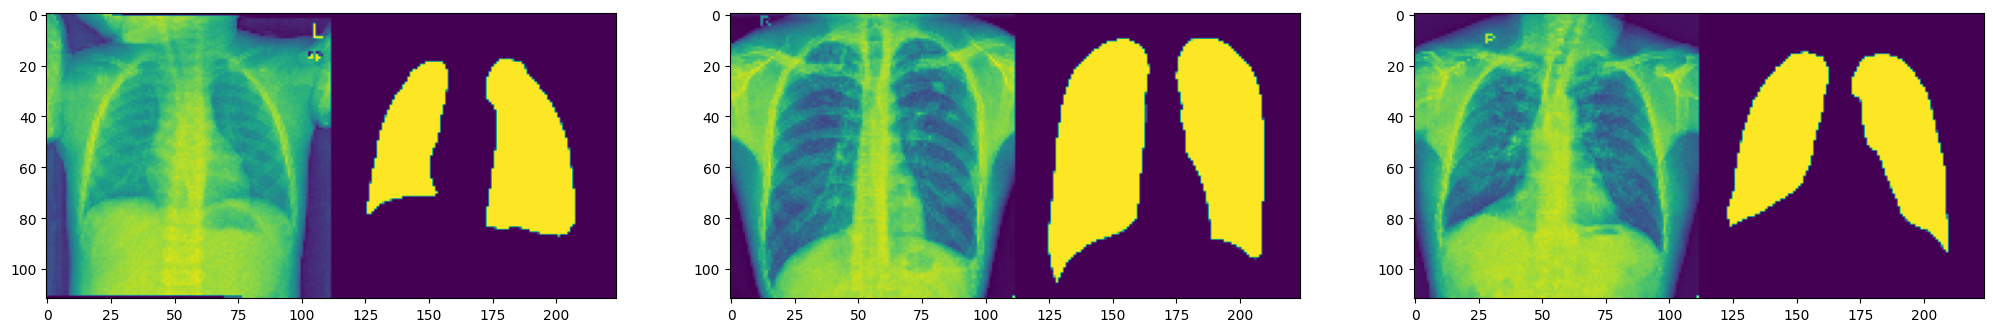

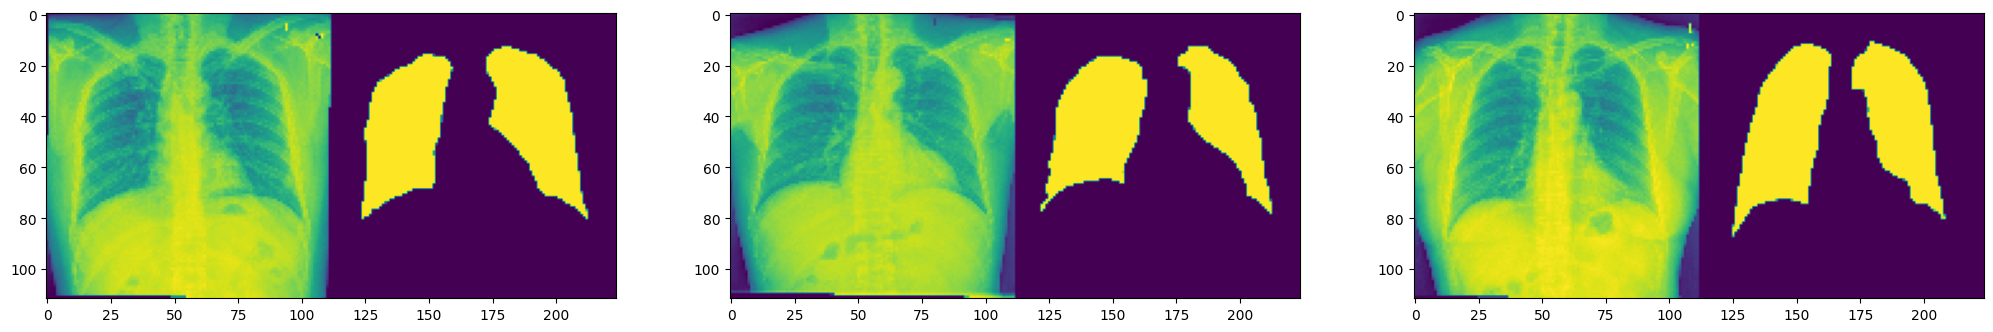

testing set


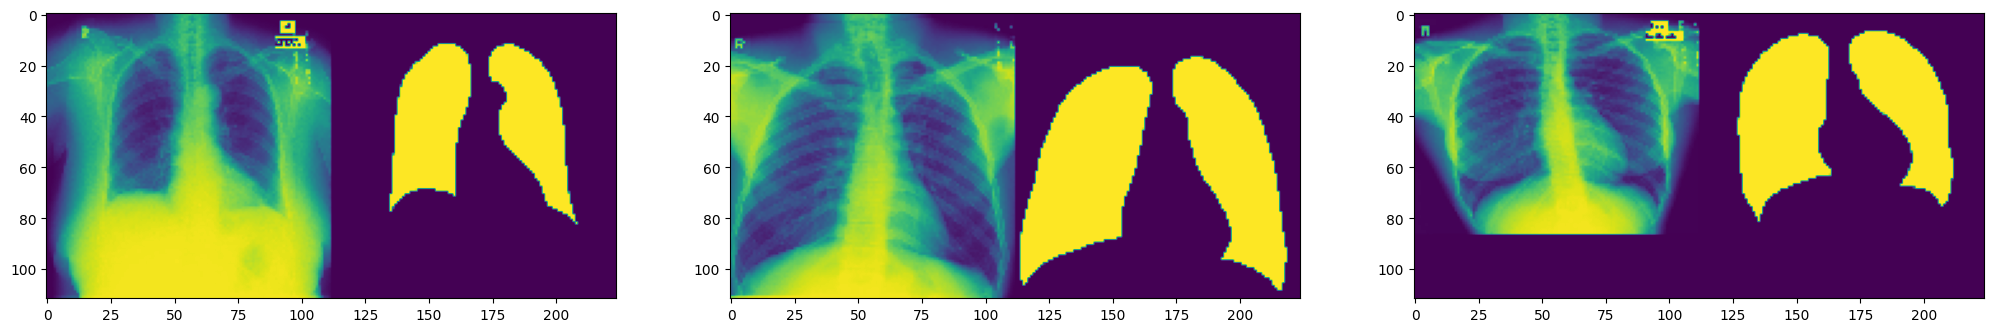

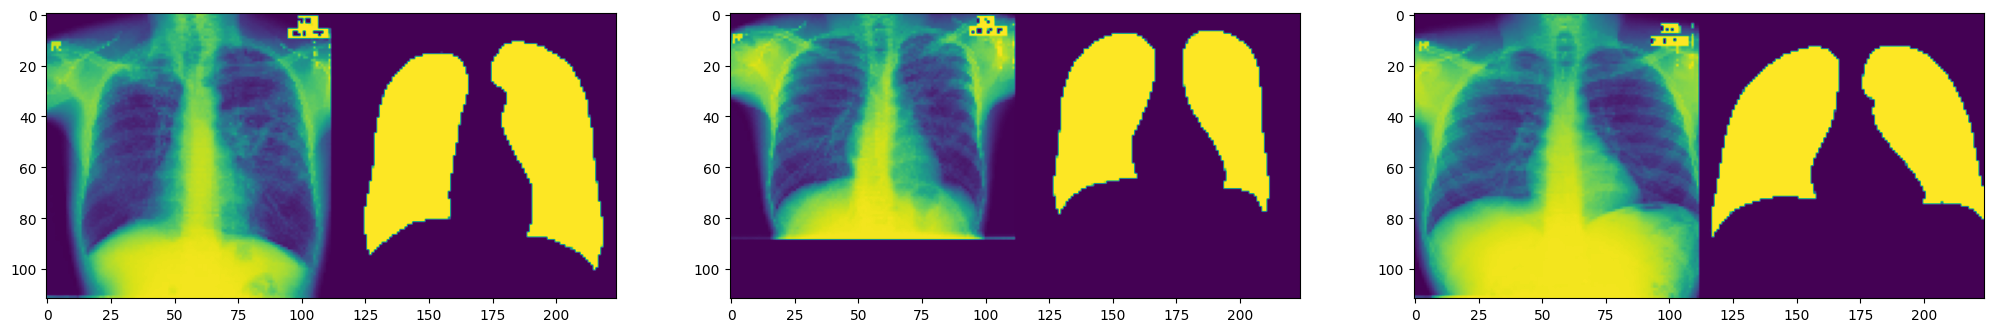

In [18]:
print("training set")
plotMask(X_train,y_train)
print("testing set")
plotMask(X_test,y_test)

In [19]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

In [20]:
print(np.shape(images))

(704, 112, 112, 1)


In [21]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(112,112,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [22]:
model = unet(input_size=(112,112,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 112, 112, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 112, 112, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 56, 56, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [23]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [24]:
from IPython.display import clear_output
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

model.compile(optimizer=Adam(lr=2e-4),
              loss=[dice_coef_loss],
           metrics = [dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0,
                                                            (mask>127).astype(np.float32),
                                                            test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg,
                                                            test_size = 0.01,
                                                            random_state = 2018)

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 16,
                  epochs = 30,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)

Epoch 1/30
40/40 [==============================] - ETA: 0s - loss: -0.4608 - dice_coef: 0.4655 - binary_accuracy: 0.6768
Epoch 1: val_loss improved from inf to -0.61616, saving model to cxr_reg_weights.best.hdf5
40/40 [==============================] - 231s 6s/step - loss: -0.4608 - dice_coef: 0.4655 - binary_accuracy: 0.6768 - val_loss: -0.6162 - val_dice_coef: 0.6162 - val_binary_accuracy: 0.8431 - lr: 0.0010
Epoch 2/30
40/40 [==============================] - ETA: 0s - loss: -0.7575 - dice_coef: 0.7594 - binary_accuracy: 0.8745
Epoch 2: val_loss improved from -0.61616 to -0.84376, saving model to cxr_reg_weights.best.hdf5
40/40 [==============================] - 214s 5s/step - loss: -0.7575 - dice_coef: 0.7594 - binary_accuracy: 0.8745 - val_loss: -0.8438 - val_dice_coef: 0.8438 - val_binary_accuracy: 0.9278 - lr: 0.0010
Epoch 3/30
40/40 [==============================] - ETA: 0s - loss: -0.8549 - dice_coef: 0.8557 - binary_accuracy: 0.9274
Epoch 3: val_loss improved from -0.84376 

In [25]:
model.save('pneumonia_detection_from chest Xray_model_improved.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
!pip install tensorflow


In [50]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
from matplotlib import pyplot as plt
from google.colab import files

ModuleNotFoundError: No module named 'tensorflow.keras'

In [48]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
from matplotlib import pyplot as plt
from google.colab import files

ModuleNotFoundError: No module named 'tensorflow.keras'

In [47]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
from matplotlib import pyplot as plt
from google.colab import files

ModuleNotFoundError: No module named 'tensorflow.keras'

In [44]:
!pip install tensorflow.keras

ERROR: Could not find a version that satisfies the requirement tensorflow.keras (from versions: none)
ERROR: No matching distribution found for tensorflow.keras


In [43]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
from matplotlib import pyplot as plt
from google.colab import files

ModuleNotFoundError: No module named 'tensorflow.keras'

# **Classifier**

In [41]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
from matplotlib import pyplot as plt
from google.colab import files

# Load the trained U-Net model
model = load_model('pneumonia_detection_from_chest_Xray_model_improved.h5',
                   custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

# Function to preprocess the input image
def preprocess_image(image_path, target_size=(112, 112)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, target_size)
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = image / 255.0  # Normalize the image
    return image

# Function to plot the original and the mask image
def plot_prediction(image, mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image.squeeze(), cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(mask.squeeze(), cmap='gray')

    plt.show()

# Function to handle image upload and prediction
def upload_and_predict():
    # Allow user to upload an image
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Preprocess the image
        image = preprocess_image(filename)
        image = np.expand_dims(image, axis=0)  # Add batch dimension

        # Predict using the loaded model
        predicted_mask = model.predict(image)

        # Plot the original image and the predicted mask
        plot_prediction(image[0], predicted_mask[0])

# Run the upload and predict function
upload_and_predict()


ModuleNotFoundError: No module named 'tensorflow.keras'